In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import xarray as xr
import scipy
from glob import glob
import cartopy.crs as ccrs
from pyresample.geometry import AreaDefinition
from pyresample import image, geometry, load_area, save_quicklook, SwathDefinition
from pyresample.kd_tree import resample_nearest
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile



In [2]:
file = 'https://podaac-opendap.jpl.nasa.gov:443/opendap/allData/insitu/L2/spurs2/saildrone/SPURS2_Saildrone1005.nc'
ds = xr.open_dataset(file)
ds

<xarray.Dataset>
Dimensions:       (time: 4609)
Coordinates:
  * time          (time) datetime64[ns] 2017-10-16 ... 2017-11-17
    longitude     (time) float64 ...
    latitude      (time) float64 ...
Data variables:
    sst           (time) float64 ...
    sss           (time) float64 ...
    solar_rad     (time) float64 ...
    long_rad      (time) float64 ...
    press         (time) float64 ...
    wind_dir      (time) float64 ...
    wind_spd_5    (time) float64 ...
    rel_humid_2   (time) float64 ...
    sp_humid_2    (time) float64 ...
    air_temp_2    (time) float64 ...
    wind_spd_10   (time) float64 ...
    rel_humid_10  (time) float64 ...
    sp_humid_10   (time) float64 ...
    air_temp_10   (time) float64 ...
Attributes:
    Conventions:                CF-1.6, ACDD 1.3, COARDS
    Metadata_Conventions:       Unidata Dataset Discovery v1.3
    featureType:                trajectory
    cdm_data_type:              Trajectory
    nodc_template_version:      NODC_NetCDF_Tra

## read in netcdf access data

In [3]:
filename = 'F:/data/cruise_data/access/rockfish_casts_2011.nc'
ds = xr.open_dataset(filename)
ds = ds.swap_dims({'row':'time'})
ds = ds.rename({'latitude':'lat','longitude':'lon'})
ds_access1 = ds.copy(deep=True)
filename = 'F:/data/cruise_data/access/rockfish_casts_2015.nc'
ds = xr.open_dataset(filename)
ds = ds.swap_dims({'row':'time'})
ds = ds.rename({'latitude':'lat','longitude':'lon'})
ds_access2 = ds.copy(deep=True)
ds_access = xr.concat((ds_access1,ds_access2),dim='time')
ds_access

<xarray.Dataset>
Dimensions:         (time: 151030)
Coordinates:
  * time            (time) datetime64[ns] 2011-05-03T08:02:00 ... 2015-06-14T11:51:00
Data variables:
    cruise          (time) |S4 b'1101' b'1101' b'1101' ... b'1505' b'1505'
    ctd_index       (time) int16 1 1 1 1 1 1 1 1 ... 246 246 246 246 246 246 246
    ctd_no          (time) int16 32767 32767 32767 32767 32767 ... 6 6 6 6 6
    station         (time) int16 473 473 473 473 473 473 ... 154 154 154 154 154
    lon             (time) float32 -124.106 -124.106 ... -123.19917 -123.19917
    lat             (time) float32 39.834167 39.834167 ... 37.6605 37.6605
    depth           (time) int16 2 4 6 8 10 12 14 ... 498 500 502 504 506 508
    temperature     (time) float32 9.8669 9.8627 9.8572 ... 6.2409 6.2327 6.2257
    salinity        (time) float32 33.016 33.0333 33.0427 ... 34.2127 34.213
    density         (time) float32 25.4252 25.4394 25.4477 ... 26.9066 26.9077
    dyn_hgt         (time) float32 nan nan nan nan

## read in excel file
    

In [11]:
filename = 'F:/data/cruise_data/access/CTD_casts_ALL_NASA_update_010819.xlsx'
df = pd.read_excel(filename, sheet_name='data')
ds = df.to_xarray()
ds

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pandas\util\_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


<xarray.Dataset>
Dimensions:           (index: 146340)
Coordinates:
  * index             (index) int64 0 1 2 3 4 ... 146336 146337 146338 146339
Data variables:
    ID_Date           (index) object '20100518-CB3_P09-C-10a' ... '20180928-4-E-31'
    Cruise            (index) object 'ACC1005' 'ACC1005' ... 'ACC1809' 'ACC1809'
    Date              (index) datetime64[ns] 2010-05-18 ... 2018-09-28
    Line              (index) object 'CB3_P09' 'CB3_P09' 'CB3_P09' ... 4 4 4
    Station           (index) object 'C' 'C' 'C' 'C' 'C' ... 'E' 'E' 'E' 'E' 'E'
    CTD_Cast          (index) object '10a' '10a' '10a' '10a' ... 31 31 31 31
    Latitude          (index) float64 38.02 38.02 38.02 ... 37.89 37.89 37.89
    Longitude         (index) float64 -123.4 -123.4 -123.4 ... -123.1 -123.1
    Bottom            (index) int64 -52 -52 -52 -52 -52 ... -85 -85 -85 -85 -85
    Depth             (index) int64 -2 -3 -4 -5 -6 -7 ... -81 -82 -83 -84 -85
    Pressure          (index) float64 2.923 4.384 5.84

## only take shallowest depth and then changes dims to time
## each cruise casts CTD multiple  times, sometimes the shallowest depth is 1 m,  sometimse 2m, sometimes 3m.  1m is  rare so here i'm choosing to jusust keep the data taken at 2m depth

In [3]:
filename = 'F:/data/cruise_data/access/CTD_casts_ALL_NASA_update_010819.xlsx'
df = pd.read_excel(filename, sheet_name='data')
ds = df.to_xarray()
subset = ds.where(ds.Depth==-2,drop=True)
subset = subset.swap_dims({'index':'Date'}).rename({'Date':'time','Longitude':'lon','Latitude':'lat'}).sortby('time')
subset



<xarray.Dataset>
Dimensions:           (time: 1156)
Coordinates:
  * time              (time) datetime64[ns] 2004-05-21 2004-05-21 ... 2018-09-28
    index             (time) int64 66159 66349 66475 ... 146079 146172 146256
Data variables:
    ID_Date           (time) object '20040521-2-W-2' ... '20180928-4-E-31'
    Cruise            (time) object 'GOF0405' 'GOF0405' ... 'ACC1809' 'ACC1809'
    Line              (time) object 2 2 2 2 2 4 4 4 4 ... 13 'N4' 'N4' 4 4 4 4 4
    Station           (time) object 'W' 'MW' 'M' 'ME' 'E' ... 'M' 'ME' 'EX' 'E'
    CTD_Cast          (time) object 2 3 4 5 6 7 8 9 ... 24 25 26 27 28 29 30 31
    lat               (time) float64 38.05 38.05 38.05 ... 37.89 37.89 37.89
    lon               (time) float64 -123.6 -123.5 -123.5 ... -123.2 -123.1
    Bottom            (time) float64 -191.0 -127.0 -69.0 ... -94.0 -85.0 -85.0
    Depth             (time) float64 -2.0 -2.0 -2.0 -2.0 ... -2.0 -2.0 -2.0 -2.0
    Pressure          (time) float64 2.922 2.923 2.

In [24]:
ds_usv = subset
minday,maxday = ds_usv.time[0],ds_usv.time[-1]
usv_day = minday
usv_day += np.timedelta64(3,'D')
print(minday.data,maxday.data)
ds_day = ds_usv.sel(time=slice(usv_day-np.timedelta64(1,'D'),usv_day+np.timedelta64(1,'D')))
print(usv_day.data)
print(ds_day.time.size)
#print(ds_day.time.min().data,ds_day.time.max().data)

2004-05-24T00:00:00.000000000 2018-09-28T00:00:00.000000000
2004-05-24T00:00:00.000000000
0


In [4]:
subset

<xarray.Dataset>
Dimensions:           (time: 1156)
Coordinates:
  * time              (time) datetime64[ns] 2004-05-21 2004-05-21 ... 2018-09-28
    index             (time) int64 66159 66349 66475 ... 146079 146172 146256
Data variables:
    ID_Date           (time) object '20040521-2-W-2' ... '20180928-4-E-31'
    Cruise            (time) object 'GOF0405' 'GOF0405' ... 'ACC1809' 'ACC1809'
    Line              (time) object 2 2 2 2 2 4 4 4 4 ... 13 'N4' 'N4' 4 4 4 4 4
    Station           (time) object 'W' 'MW' 'M' 'ME' 'E' ... 'M' 'ME' 'EX' 'E'
    CTD_Cast          (time) object 2 3 4 5 6 7 8 9 ... 24 25 26 27 28 29 30 31
    lat               (time) float64 38.05 38.05 38.05 ... 37.89 37.89 37.89
    lon               (time) float64 -123.6 -123.5 -123.5 ... -123.2 -123.1
    Bottom            (time) float64 -191.0 -127.0 -69.0 ... -94.0 -85.0 -85.0
    Depth             (time) float64 -2.0 -2.0 -2.0 -2.0 ... -2.0 -2.0 -2.0 -2.0
    Pressure          (time) float64 2.922 2.923 2.

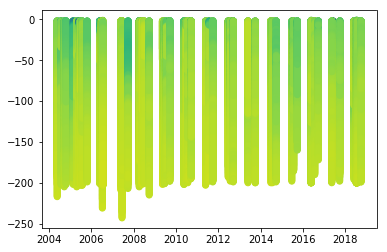

In [23]:
plt.scatter(ds.Date.dt.year+ds.Date.dt.dayofyear/365,ds.Depth,c=ds.Salinity)

In [55]:
#print out shallowest depth for each cruise to explore data
i=0
while i < 146340:
    tem=ds.where(ds.Cruise==ds.Cruise[i],drop=True)
    print(ds.Cruise[i].data,tem.Depth.max().data)
    i+=tem.index.size

ACC1005 -2.0
ACC1006 -2.0
ACC1007 -2.0
ACC1009 -2.0
ACC1105 -2.0
ACC1107 -2.0
ACC1109 -2.0
ACC1206 -2.0
ACC1207 -2.0
ACC1209 -2.0
ACC1305 -2.0
ACC1309 -2.0
ACC1406 -2.0
ACC1407 -2.0
ACC1409 -2.0
ACC1506 -2.0
ACC1507 -2.0
ACC1509 -2.0
ACC1605 -1.0
ACC1607 -2.0
ACC1609 -2.0
ACC1705 -2.0
ACC1709 -2.0
ACC1805 -2.0
ACC1807 -1.0
ACD1807 -1.0
ACM1705 -2.0
GOF0405 -2.0
GOF0407 -2.0
GOF0409 -2.0
GOF0410 -2.0
GOF0502 -2.0
GOF0504 -2.0
GOF0505 -2.0
GOF0506 -2.0
GOF0507 -2.0
GOF0510 -2.0
GOF0605 -2.0
GOF0606 -2.0
GOF0607 -1.0
GOF0705 -2.0
GOF0706 -2.0
GOF0709 -2.0
GOF0804 -2.0
GOF0805 -2.0
GOF0806 -2.0
GOF0809 -2.0
GOF0905 -2.0
GOF0906 -2.0
GOF0907 -2.0
GOF0909 -2.0
ACC1809 -2.0


In [56]:
tem=ds.where(ds.Cruise=='ACC1605',drop=True)
tem

<xarray.Dataset>
Dimensions:           (index: 3920)
Coordinates:
  * index             (index) int64 41827 41828 41829 ... 45744 45745 45746
Data variables:
    ID_Date           (index) object '20160515-10-E-1' ... '20160521-N13-EN-35'
    Cruise            (index) object 'ACC1605' 'ACC1605' ... 'ACC1605' 'ACC1605'
    Date              (index) datetime64[ns] 2016-05-15 ... 2016-05-21
    Line              (index) object '10' '10' '10' '10' ... 'N13' 'N13' 'N13'
    Station           (index) object 'E' 'E' 'E' 'E' 'E' ... 'EN' 'EN' 'EN' 'EN'
    CTD_Cast          (index) object 1 1 1 1 1 1 1 1 ... 35 35 35 35 35 35 35 35
    Latitude          (index) float64 37.36 37.36 37.36 ... 38.38 38.38 38.38
    Longitude         (index) float64 -122.5 -122.5 -122.5 ... -123.1 -123.1
    Bottom            (index) float64 -22.0 -22.0 -22.0 ... -26.0 -26.0 -26.0
    Depth             (index) float64 -3.0 -4.0 -5.0 -6.0 ... -24.0 -25.0 -26.0
    Pressure          (index) float64 4.384 5.845 7.306 

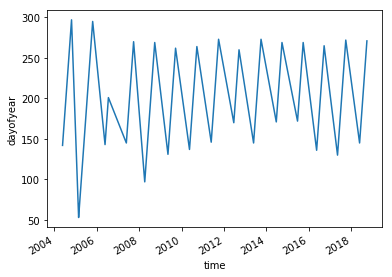

In [30]:
subset.time.dt.dayofyear.plot()

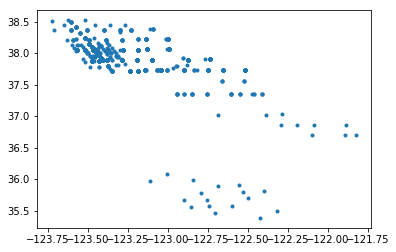

In [37]:
plt.plot(subset.lon,subset.lat,'.')

NoCredentialsError: Unable to locate credentials